# Point Mass Car with MPC Path Planner

The object of this notebook is to develop a simple path planner for a "point mass car" using Model Predictive Control. This is a common practice in autonomous ground vehicles, because the model predictive controller uses a very simplistic model of the vehicle (a point mass) to determine a feasible path within some acceleration bounds around some obstacle, and then a low-level controller on the vehicle follows that path.


In [12]:
from IPython.display import Image
Image('pointmass_mpc.png')

## Assumptions of the model

We will proceed assuming that the vehicle *only* swerves, and the obstacle we see *only moves in the y-direction with constant velocity*. We will use an Euler approximation for numerical integration of the equations of motion.

## Model predictive control setup

Model predictive control is actually a fairly simple paradigm. The vehicle predicts its own behavior and the behavior of the obstacle $N_p$ timesteps $t_p$ into the future for some initial guess of its inputs at each timestep on the prediction horizon from $t\rightarrow+N_pt_p$, and then computes the value of some objective function $J(\vec{x}_v,\vec{x_o},\vec{u})$ for that input vector $\vec{u}$. Then, it uses an optimizer to compute the optimal input trajectory $\vec{u}^\star$, and its input at time $t$ is $\vec{u}^\star(0)$. At the next timestep, the process is repeated, creating implicit feedback to complement the explicit feedforward of the optimization procedure.

This is provably stable for certain conditions, and is fairly widely accepted in practice. For our case, our objective function will be a weighted sum of distance from lane center, input penalty (penalizing lateral acceleration), and distance from the predicted position of the obstacle.

$$ J = \sum_{k=1}^{N_p} K_1(k){u_v^2(k)} + K_2(k) y_v^2(k) + + K_3(k) \dot{y}_v^2(k)+K_4(k) \frac{1}{(y_v(k)-y_o(k)+\delta)^2}$$

Notice that the $x$ position of the vehicle is not in the optimizer. This is on purpose. We will also want to constrain the y-acceleration allowed in the optimization, because we want to make sure the path is feasible for a vehicle to follow. We will subject the optimization to the constraint that $|u|<=u_{max}$, which we'll set in the linear tire region for a vehicle (for now). We can do this using the "bounds" parameter in scipy.minimize, which is the function we'll use for the optimization. 

## Setup of parameters

Below, you will see how we set up the vehicle, the obstacle, and the optimizer. 

In [13]:
%matplotlib inline
from numpy import *
from scipy.optimize import minimize
from matplotlib.pyplot import *

#gravitational constant
g = 9.81 #m/s/s

#vehicle parameters
uvmax = 0.6*g #the maximum lateral acceleration for the vehicle.
xdotv = 10 #m/s
xv0 = 0#initial x-position of vehicle
yv0=0 #initial y position of vehicle
ydotv0 = 0# initial y velocity of vehicle
u0 = 0#initial value of vehicle y-acceleration

#obstacle variables
xo = 10 #meters, ahead
yo = 0#put the obstacle right in the road center

#environment variables
ylane_right = -2 #meters
ylane_left = 2 #meters, left lane boundary
W = ylane_left-ylane_right

#prediction variables
Np = 100#predict 10 steps into the future
dtP = 0.01#predict in 0.1 second increments.

#optimizer variables
K1 = .1*ones(Np)#weight on input
K2 = 1*ones(Np)#weight on y vehicle
K3 = zeros(Np);K3[-1] = 1000#weight on terminal y-velocity. Only Penalize TERMINAL!!
K4 = 1*ones(Np)#weight on distance from obstacle.
delta = 0.1 # term added to inverse to avoid division by zero

#simulation variables
dt = 0.01 #seconds, the timestep with which we will update the actual simulation.


## Setup of Point-Mass Vehicle Class

This is a simple class that updates the vehicle's position and velocity in 2 dimensions assuming that there is no acceleration/braking allowed and that acceleration in the y-direction is constant over the prediction horizon. The model uses a very simple Euler model for integration. This will be updated eventually, but it exists here just to explain the concept.

In [14]:
class PointMassVehicle:
    def __init__(self,x=0,y=0,xdot=10,ydot=0,dT=0.01,umax = 5):
        self.x = x#initial x position of vehicle
        self.y = y#initial y position of vehicle
        self.xdot = xdot#vehicle forward velocity
        self.ydot = ydot
        self.umax = umax#maximum lateral acceleration
        self.dT = dT
    def updateStates(self,u):
        self.ydot = self.ydot+u*self.dT #euler update of vehicle velocity (constant acceleration)
        self.x = self.x+self.xdot*self.dT#euler update of vehicle position (constant velocity)
        self.y = self.y+self.ydot*self.dT
        #clamp acceleration at the maximum
        if abs(u)>self.umax:
            u = self.umax*sign(u)
        #update y velocity for next timestep

        return array([self.x,self.xdot,self.y,self.ydot])
        

## Setup of Objective and Constraint Functions

Now we need to set up two functions-- one will represent the constraint on vehicle maximum acceleration, and the other will represent our objective function J.

In [15]:
def ObjectiveFn_staticobstacle(uvec,yobstacle,xvehicle,pmvehicle,K1,K2,K3):
        #first reset the predictive model's states to where we are currently. 
        pmvehicle.x,pmvehicle.xdot,pmvehicle.y,pmvehicle.ydot = xvehicle[0],xvehicle[1],xvehicle[2],xvehicle[3]
        J = 0 #initialize the objective to zero
        #now loop through and update J for every timestep in the prediction horizon.
        for ind in range(0,len(uvec)): #compute for each step in the prediction horizon
            #print ind
            xv = pmvehicle.updateStates(uvec[ind])
            J = J + K1[ind]*uvec[ind]**2 + K2[ind] *(xv[2])**2 + K3[ind]*xv[3]**2+K4[ind] * 1/(xv[2]-yobstacle[ind]+delta)**2
        return J

## Setup of optimization for a single time step

To get started and see how the optimizer really works, we'll first compute the optimal input sequence in open-loop for our initial conditions, and then we'll run a simulation of our vehicle performing the "optimal inputs" without recalculating the optimal trajectory at each timestep. By the principle of optimality, if we had no model mismatch and a perfectly straight road, the optimal trajectory we computed at the first timestep would be the same as all of the other optimal trajectories we'd compute along the way.

In the following block, we'll compute the optimal input (acceleration) trajectory, and in the block following that step, we'll simulate the vehicle moving according to that trajectory and plot the results. You'll see that the vehicle very nicely avoids the obstacle and stays within the lane boundaries, ending up with a final velocity of 0 m/s. This represents a beautiful lane change around the obstacle.

In [16]:
u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
y_obs = yo*ones(Np)
xvehicle = array([xv0,xdotv,yv0,ydotv0])
#set up the bounds on umax. This needs to be a list of tuples (min,max)
bounds = [(-uvmax,uvmax)]
for ind in range(1,len(u0)):
    bounds.insert(0,(-uvmax,uvmax))
#now we will use the minimize function to find out what the optimal input to the point mass vehicle is.
#we are just doing this for one timestep now.

umpc = minimize(ObjectiveFn_staticobstacle,u0,args=(y_obs,xvehicle,vehiclepredict,K1,K2,K3),bounds=bounds,method='SLSQP')


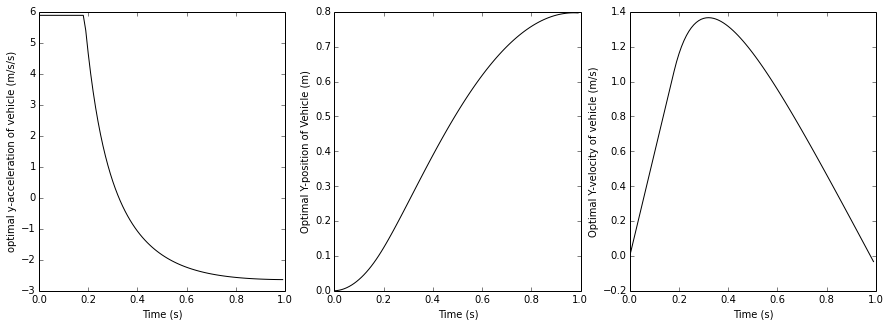

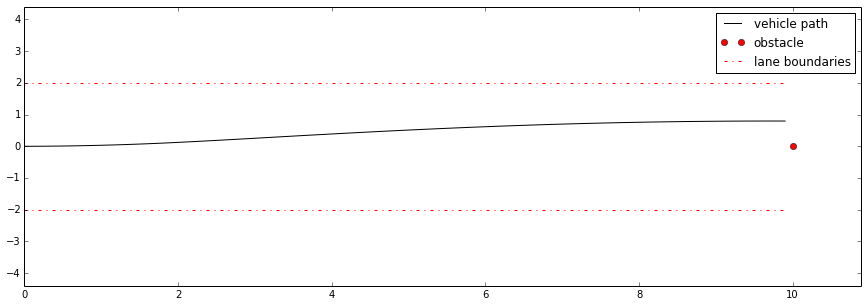

In [17]:
#now we will plot the optimal U and simulate the position of the vehicle.
opt_u = umpc.x #we will assume the vehicle follows this exact u trajectory with no feedback
#now we'll simulate the vehicle.
vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
t = linspace(0,(Np-1)*dtP,Np)
for ind in range(1,len(t)):
    xvehicle = vehiclesimulate.updateStates(opt_u[ind])
    xvehicle_store = vstack((xvehicle_store,xvehicle))

#now plot the input vector U and the vehicle y-position and y-velocity
figure(figsize=(15,5))
subplot(1,3,1)
plot(t,opt_u,'k')
xlabel('Time (s)')
ylabel('optimal y-acceleration of vehicle (m/s/s)')
subplot(1,3,2)
plot(t,xvehicle_store[:,2],'k')
xlabel('Time (s)')
ylabel('Optimal Y-position of Vehicle (m)')
subplot(1,3,3)
plot(t,xvehicle_store[:,3],'k')
xlabel('Time (s)')
ylabel('Optimal Y-velocity of vehicle (m/s)')

figure(figsize=(15,5))
plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',xo,yo,'ro',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
ylim([-1.1*W,1.1*W])
xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
legend(['vehicle path','obstacle','lane boundaries'])


## What if the obstacle moves?

This time, let's simulate a case in which the obstacle has some motion over time. To make it simple, we'll create an obstacle that moves with a constant velocity in the positive y-direction. We'll make the obstacle reach 1.0 meters just as the vehicle reaches it, and we'll actually implement the model predictive controller this time. In other words, We'll use the first element of the optimal input at each timestep, and then re-optimize at the next timestep. Our objective function and our optimizer have no knowledge of the fact that the obstacle can move, so the optimizer will still assume that the obstacle stays stationary. Let's see how that works.

As you can see, the moving obstacle did change the path our vehicle ended up taking, and changed the optimal input sequence over time. But that simulation took way too long. Typically, when people run MPC controllers, the optimizer runs on a fairly coarse timestep.  I will show you how this is done below. We'll hold the input to the vehicle at the last computed "optimal" input until we're ready to do another optimization. In this case, the prediction timestep will be 0.1 seconds, and the simulation timestep will be 0.01 seconds, meaning that we'll only predict 10 steps in the future at any given time.

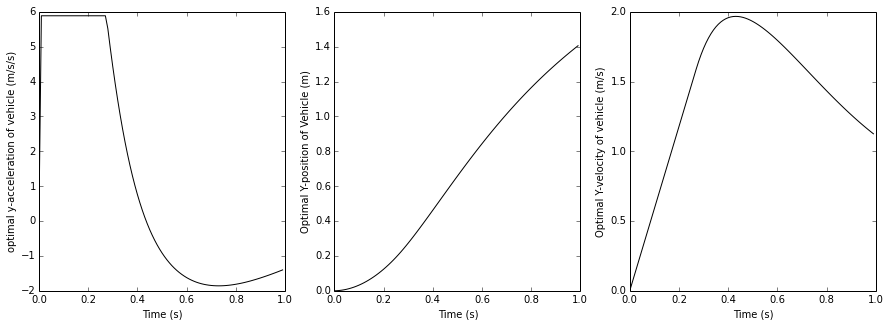

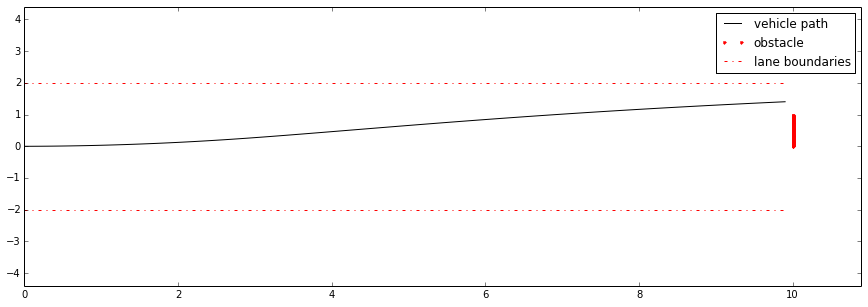

In [18]:
dtP = 0.1
Np = 10

dt = 0.01
simtime = 1 #second


#set up things that will stay the same over time
u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
y_obs = yo*ones(Np)
xvehicle = array([xv0,xdotv,yv0,ydotv0])
#set up the bounds on umax. This needs to be a list of tuples (min,max)
bounds = [(-uvmax,uvmax)]
for ind in range(1,len(u0)):
    bounds.insert(0,(-uvmax,uvmax))


#set up time and time-dependent variables
vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
u_store = array([0])#store the first value of each optimal input 
t = arange(0,simtime,dt)#time vector
y_obstacle = arange(0,1,dt)#make the obstacle move
for ind in range(1,len(t)):
    #pull out the y-position of the obstacle, make into a constant array    
    yobs_now = y_obstacle[ind]*ones(Np)
    umpc = minimize(ObjectiveFn_staticobstacle,u0,args=(yobs_now,xvehicle,vehiclepredict,K1,K2,K3),bounds=bounds,method='SLSQP',options={'disp': False})
    opt_u = umpc.x#pull out the optimal input
    xvehicle = vehiclesimulate.updateStates(opt_u[0])
    xvehicle_store = vstack((xvehicle_store,xvehicle))
    u_store = append(u_store,opt_u[0])


#now plot the input vector U and the vehicle y-position and y-velocity
figure(figsize=(15,5))
subplot(1,3,1)
plot(t,u_store,'k')
xlabel('Time (s)')
ylabel('optimal y-acceleration of vehicle (m/s/s)')
subplot(1,3,2)
plot(t,xvehicle_store[:,2],'k')
xlabel('Time (s)')
ylabel('Optimal Y-position of Vehicle (m)')
subplot(1,3,3)
plot(t,xvehicle_store[:,3],'k')
xlabel('Time (s)')
ylabel('Optimal Y-velocity of vehicle (m/s)')

figure(figsize=(15,5))
plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',xo*ones(len(t)),y_obstacle,'r.',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
ylim([-1.1*W,1.1*W])
xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
legend(['vehicle path','obstacle','lane boundaries'])

That ran much, much faster. 

## What if the car knows the velocity of the obstacle?

We will now explore the case where the car has some knowledge of how the obstacle will move. We'll need to include this model in the yobs_now vector we send to the optimizer. Let's see what that looks like below:

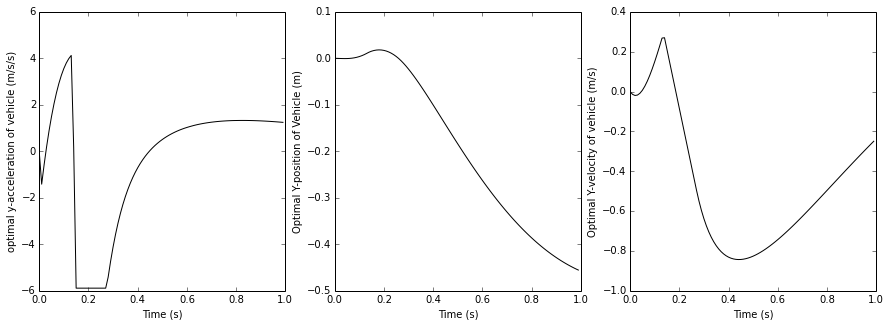

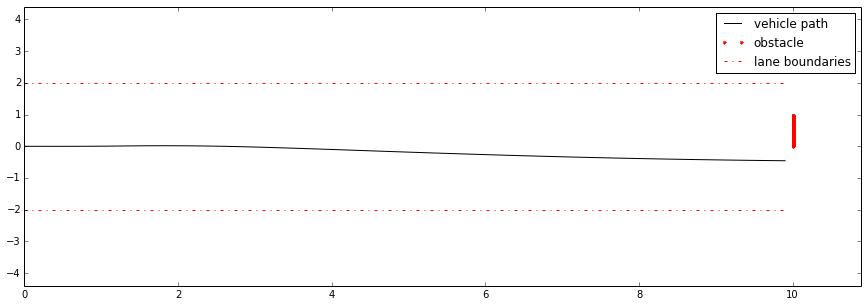

In [19]:
dtP = 0.1
Np = 10

dt = 0.01
simtime = 1 #second


#set up things that will stay the same over time
u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
y_obs = yo*ones(Np)
xvehicle = array([xv0,xdotv,yv0,ydotv0])
#set up constraint on the optimization
#set up the bounds on umax. This needs to be a list of tuples (min,max)
bounds = [(-uvmax,uvmax)]
for ind in range(1,len(u0)):
    bounds.insert(0,(-uvmax,uvmax))


#set up time and time-dependent variables
vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
u_store = array([0])#store the first value of each optimal input 
t = arange(0,simtime,dt)#time vector

vel_obstacle = 1.0 #m/s
y_obstacle = zeros(len(t))#initialize obstacle position
y_obstacle[0]=yo #initial value
for ind in range(1,len(t)):
    y_obstacle[ind] = y_obstacle[ind-1]+dt*vel_obstacle#update position 
    
#now create a function that the MPC algorithm uses to predict the obstacle's position
def MPC_predictobstaclepos(yo_now,vo_now,nsteps,dt):
    yobs_now = zeros(nsteps)
    yobs_now[0] = yo_now
    for ind in range(1,nsteps):
        yobs_now[ind] = yobs_now[ind-1]+dt*vo_now
    return yobs_now

for ind in range(1,len(t)):
    #pull out the y-position of the obstacle, use to predict future position for MPC algorithm
    yobs_now = MPC_predictobstaclepos(y_obstacle[ind],vel_obstacle,Np,dtP)#predict obstacle position
    #use current states, objective function, bounds, and predicted obstacle position to compute optimal input
    umpc = minimize(ObjectiveFn_staticobstacle,u0,args=(yobs_now,xvehicle,vehiclepredict,K1,K2,K3),bounds=bounds,method='SLSQP',options={'disp': False})
    opt_u = umpc.x#pull out the optimal input
    xvehicle = vehiclesimulate.updateStates(opt_u[0])
    xvehicle_store = vstack((xvehicle_store,xvehicle))
    u_store = append(u_store,opt_u[0])


#now plot the input vector U and the vehicle y-position and y-velocity
figure(figsize=(15,5))
subplot(1,3,1)
plot(t,u_store,'k')
xlabel('Time (s)')
ylabel('optimal y-acceleration of vehicle (m/s/s)')
subplot(1,3,2)
plot(t,xvehicle_store[:,2],'k')
xlabel('Time (s)')
ylabel('Optimal Y-position of Vehicle (m)')
subplot(1,3,3)
plot(t,xvehicle_store[:,3],'k')
xlabel('Time (s)')
ylabel('Optimal Y-velocity of vehicle (m/s)')

figure(figsize=(15,5))
plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',xo*ones(len(t)),y_obstacle,'r.',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
ylim([-1.1*W,1.1*W])
xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
legend(['vehicle path','obstacle','lane boundaries'])

### WOAH! WE PASSED THE OBSTACLE ON THE OTHER SIDE! COOL!

This shows us that having a model of what the obstacle is doing is *definitely* important. One of the most interesting things about MPC path planners and collision avoidance systems is the possibility that a mismatch between the modeled and actual dynamics of an obstacle could have disastrous consequences. Let's create a function below that runs a simulation for a particular initial condition of the obstacle. We'll still let our controller have a perfect model of the obstacle (which moves), but we'll just explore the space of possible positions and velocities of the obstacle when it "comes into view" of our controller.

In [20]:
def runMPCsim(yobs_init,ydotobs_init):
    dtP = 0.1
    Np = 10
    dt = 0.01
    simtime = 1 #second
    #set up things that will stay the same over time
    u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
    vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
    xvehicle = array([xv0,xdotv,yv0,ydotv0])
    #set up the bounds on umax. This needs to be a list of tuples (min,max)
    bounds = [(-uvmax,uvmax)]
    for ind in range(1,len(u0)):
        bounds.insert(0,(-uvmax,uvmax))


    #set up time and time-dependent variables
    vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
    xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
    u_store = array([0])#store the first value of each optimal input 
    t = arange(0,simtime,dt)#time vector

    vel_obstacle = ydotobs_init #m/s
    y_obstacle = zeros(len(t))#initialize obstacle position
    y_obstacle[0]=yobs_init #initial value
    for ind in range(1,len(t)):
        y_obstacle[ind] = y_obstacle[ind-1]+dt*vel_obstacle#update position 

    #now create a function that the MPC algorithm uses to predict the obstacle's position
    def MPC_predictobstaclepos(yo_now,vo_now,nsteps,dt):
        yobs_now = zeros(nsteps)
        yobs_now[0] = yo_now
        for ind in range(1,nsteps):
            yobs_now[ind] = yobs_now[ind-1]+dt*vo_now
        return yobs_now

    for ind in range(1,len(t)):
        #pull out the y-position of the obstacle, use to predict future position for MPC algorithm
        yobs_now = MPC_predictobstaclepos(y_obstacle[ind],vel_obstacle,Np,dtP)#predict obstacle position
        #use current states, objective function, bounds, and predicted obstacle position to compute optimal input
        umpc = minimize(ObjectiveFn_staticobstacle,u0,args=(yobs_now,xvehicle,vehiclepredict,K1,K2,K3),bounds=bounds,method='SLSQP',options={'disp': False})
        opt_u = umpc.x#pull out the optimal input
        xvehicle = vehiclesimulate.updateStates(opt_u[0])
        xvehicle_store = vstack((xvehicle_store,xvehicle))
        u_store = append(u_store,opt_u[0])
        
    return y_obstacle[-1]-xvehicle_store[-1,2]#return pass margin of the vehicle around the obstacle


Now, let's create a space of possibilities for the obstacle's states, and let our MPC controller try to avoid the obstacle a bunch of times. Then, we'll be able to plot (in 3D) the relationship between initial position and velocity of the obstacle and the "miss" distance. We'll keep some "margin" as our boundary defining a collision.

In [21]:
possible_yobs = linspace(-W/2,W/2,10)#50 initial locations
possible_ydotobs = linspace(0.1,3,10)#50 possible velocities for the pedestrian

pass_margin = zeros((len(possible_yobs),len(possible_ydotobs)))

for posind in range(0,len(possible_yobs)):
    for velind in range(0,len(possible_ydotobs)):
        pass_margin[posind,velind]=runMPCsim(possible_yobs[posind],possible_ydotobs[velind])


        

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
import IPython.display as IPdisplay
import glob
from PIL import Image as PIL_Image
from images2gif2 import writeGif

def make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin,miss):


    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for posind in range(0,len(possible_yobs)):
        for velind in range(0,len(possible_ydotobs)):
            if abs(pass_margin[posind,velind])>miss:
                ax.scatter(possible_yobs[posind],possible_ydotobs[velind],pass_margin[posind,velind],c='k')
            else:
                ax.scatter(possible_yobs[posind],possible_ydotobs[velind],pass_margin[posind,velind],c='r')

    for n in range(0, 100):
        if n >= 20 and n <= 22:
            ax.set_xlabel('')
            ax.set_ylabel('') #don't show axis labels while we move around, it looks weird
            ax.elev = ax.elev-0.5 #start by panning down slowly
        if n >= 23 and n <= 36:
            ax.elev = ax.elev-1.0 #pan down faster
        if n >= 37 and n <= 60:
            ax.elev = ax.elev-.5
            ax.azim = ax.azim+2.1 #pan down faster and start to rotate
        if n >= 61 and n <= 64:
            ax.elev = ax.elev-1.0
            ax.azim = ax.azim+1.1 #pan down slower and rotate same speed
        if n >= 65 and n <= 73:
            ax.elev = ax.elev-0.5
            ax.azim = ax.azim+1.1 #pan down slowly and rotate same speed
        if n >= 74 and n <= 76:
            ax.elev = ax.elev-0.2
            ax.azim = ax.azim+0.5 #end by panning/rotating slowly to stopping position
        if n == 77: #add axis labels at the end, when the plot isn't moving around
            ax.set_xlabel('obstacle start location (m)')
            ax.set_ylabel('obstacle velocity (m/s)')
            ax.set_zlabel('miss margin (m)')

        savefig('snaps/' + gif_filename + '/img' + str(n).zfill(3) + '.png',
                    bbox_inches='tight')


    close()
    path = 'snaps/' + gif_filename + '/*.png'
    #print path
    images = [PIL_Image.open(image) for image in glob.glob(path)]
    #print images
    file_path_name = gif_filename + '.gif'
    #print file_path_name
    writeGif(file_path_name, images, duration=0.1)

gif_filename = 'mpc_gif'
miss = 0.5 #meters, the acceptable miss margin
make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin,miss)

ImportError: No module named images2gif2

In [ ]:
IPdisplay.Image(url=gif_filename+'.gif')    

Looking at the above plot, you can see that even with a perfect model of the obstacle's dynamics, a fairly tame objective function, and linear, simplistic dynamics for the obstacle and vehicle, certain combinations of obstacle initial position and velocity result in a swerve maneuver that's less than our "miss" threshold, indicating that we would have a collision. You can also see that the side on which the MPC algorithm passes the obstacle has a bifurcation in it! This is very interesting.

In conclusion, this is an interesting platform to start exploring "mismatched" models of the obstacle dynamics in the eyes of the MPC controller... in addition, we could start considering an obstacle that also tries to avoid the vehicle using its own MPC algorithm. This is likely much closer to what happens in a vehicle-vehicle or vehicle-animal collision.

Let's do the whole thing again, but crank up the weight on the distance from the obstacle. That might get rid of the "crash" cases.

We're also going to turn the gif feature you see above into a function.

In [ ]:
import os
K4 = 10*ones(Np)#weight on distance from obstacle.
possible_yobs = linspace(-W/2,W/2,10)#50 initial locations
possible_ydotobs = linspace(0.1,3,10)#50 possible velocities for the pedestrian
miss = 0.5 #meters, the acceptable miss margin

pass_margin = zeros((len(possible_yobs),len(possible_ydotobs)))
#keep track of cases we should look at (where we collide)
fail_case_yobs = array([])
fail_case_ydotobs = array([])

for posind in range(0,len(possible_yobs)):
    for velind in range(0,len(possible_ydotobs)):
        pass_margin[posind,velind]=runMPCsim(possible_yobs[posind],possible_ydotobs[velind])
        if abs(pass_margin[posind,velind])<miss:
            fail_case_yobs = append(fail_case_yobs,possible_yobs[posind])
            fail_case_ydotobs = append(fail_case_ydotobs,possible_ydotobs[velind])
        
gif_filename = 'mpc_gif2'
os.system('mkdir snaps/'+gif_filename)

make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin,miss)
IPdisplay.Image(url=gif_filename+'.gif')    

Because we kept track of the cases where we had a collision, let's look at these cases and see what actually happened. Let's look at the first case.

In [ ]:
dtP = 0.1
Np = 10

dt = 0.01
simtime = 1 #second


#set up things that will stay the same over time
u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
xvehicle = array([xv0,xdotv,yv0,ydotv0])
#set up constraint on the optimization
#set up the bounds on umax. This needs to be a list of tuples (min,max)
bounds = [(-uvmax,uvmax)]
for ind in range(1,len(u0)):
    bounds.insert(0,(-uvmax,uvmax))


#set up time and time-dependent variables
vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
u_store = array([0])#store the first value of each optimal input 
t = arange(0,simtime,dt)#time vector

vel_obstacle = fail_case_ydotobs[0] #m/s
y_obstacle = zeros(len(t))#initialize obstacle position
y_obstacle[0]= fail_case_yobs[0] #initial value
for ind in range(1,len(t)):
    y_obstacle[ind] = y_obstacle[ind-1]+dt*vel_obstacle#update position 
    

for ind in range(1,len(t)):
    #pull out the y-position of the obstacle, use to predict future position for MPC algorithm
    yobs_now = MPC_predictobstaclepos(y_obstacle[ind],vel_obstacle,Np,dtP)#predict obstacle position
    #use current states, objective function, bounds, and predicted obstacle position to compute optimal input
    umpc = minimize(ObjectiveFn_staticobstacle,u0,args=(yobs_now,xvehicle,vehiclepredict,K1,K2,K3),bounds=bounds,method='SLSQP',options={'disp': False})
    opt_u = umpc.x#pull out the optimal input
    xvehicle = vehiclesimulate.updateStates(opt_u[0])
    xvehicle_store = vstack((xvehicle_store,xvehicle))
    u_store = append(u_store,opt_u[0])


#now plot the input vector U and the vehicle y-position and y-velocity
figure(figsize=(15,5))
subplot(1,3,1)
plot(t,u_store,'k')
xlabel('Time (s)')
ylabel('optimal y-acceleration of vehicle (m/s/s)')
subplot(1,3,2)
plot(t,xvehicle_store[:,2],'k')
xlabel('Time (s)')
ylabel('Optimal Y-position of Vehicle (m)')
subplot(1,3,3)
plot(t,xvehicle_store[:,3],'k')
xlabel('Time (s)')
ylabel('Optimal Y-velocity of vehicle (m/s)')

figure(figsize=(15,5))
plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',xo*ones(len(t)),y_obstacle,'r.',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
ylim([-1.1*W,1.1*W])
xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
legend(['vehicle path','obstacle','lane boundaries'])

What about the "last" case where we had a collision? The above behavior is really, really weird. It's as if the vehicle "can't decide" and the input trajectory limit-cycles. Let's see a case where the car makes a decision.

In [ ]:
dtP = 0.1
Np = 10

dt = 0.01
simtime = 1 #second


#set up things that will stay the same over time
u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
xvehicle = array([xv0,xdotv,yv0,ydotv0])
#set up constraint on the optimization
#set up the bounds on umax. This needs to be a list of tuples (min,max)
bounds = [(-uvmax,uvmax)]
for ind in range(1,len(u0)):
    bounds.insert(0,(-uvmax,uvmax))


#set up time and time-dependent variables
vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
u_store = array([0])#store the first value of each optimal input 
t = arange(0,simtime,dt)#time vector

vel_obstacle = fail_case_ydotobs[-1] #m/s
y_obstacle = zeros(len(t))#initialize obstacle position
y_obstacle[0]= fail_case_yobs[-1] #initial value
for ind in range(1,len(t)):
    y_obstacle[ind] = y_obstacle[ind-1]+dt*vel_obstacle#update position 
    

for ind in range(1,len(t)):
    #pull out the y-position of the obstacle, use to predict future position for MPC algorithm
    yobs_now = MPC_predictobstaclepos(y_obstacle[ind],vel_obstacle,Np,dtP)#predict obstacle position
    #use current states, objective function, bounds, and predicted obstacle position to compute optimal input
    umpc = minimize(ObjectiveFn_staticobstacle,u0,args=(yobs_now,xvehicle,vehiclepredict,K1,K2,K3),bounds=bounds,method='SLSQP',options={'disp': False})
    opt_u = umpc.x#pull out the optimal input
    xvehicle = vehiclesimulate.updateStates(opt_u[0])
    xvehicle_store = vstack((xvehicle_store,xvehicle))
    u_store = append(u_store,opt_u[0])


#now plot the input vector U and the vehicle y-position and y-velocity
figure(figsize=(15,5))
subplot(1,3,1)
plot(t,u_store,'k')
xlabel('Time (s)')
ylabel('optimal y-acceleration of vehicle (m/s/s)')
subplot(1,3,2)
plot(t,xvehicle_store[:,2],'k')
xlabel('Time (s)')
ylabel('Optimal Y-position of Vehicle (m)')
subplot(1,3,3)
plot(t,xvehicle_store[:,3],'k')
xlabel('Time (s)')
ylabel('Optimal Y-velocity of vehicle (m/s)')

figure(figsize=(15,5))
plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',xo*ones(len(t)),y_obstacle,'r.',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
ylim([-1.1*W,1.1*W])
xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
legend(['vehicle path','obstacle','lane boundaries'])

In [ ]:
import os
K4 = 10*ones(Np)#weight on distance from obstacle.
K3[-1]=0
possible_yobs = linspace(-W/2,W/2,10)#50 initial locations
possible_ydotobs = linspace(0.1,3,10)#50 possible velocities for the pedestrian
miss = 0.5 #meters, the acceptable miss margin

pass_margin = zeros((len(possible_yobs),len(possible_ydotobs)))
#keep track of cases we should look at (where we collide)
fail_case_yobs = array([])
fail_case_ydotobs = array([])

for posind in range(0,len(possible_yobs)):
    for velind in range(0,len(possible_ydotobs)):
        pass_margin[posind,velind]=runMPCsim(possible_yobs[posind],possible_ydotobs[velind])
        if abs(pass_margin[posind,velind])<miss:
            fail_case_yobs = append(fail_case_yobs,possible_yobs[posind])
            fail_case_ydotobs = append(fail_case_ydotobs,possible_ydotobs[velind])
        
gif_filename = 'mpc_gif3'
os.system('mkdir snaps/'+gif_filename)

make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin,miss)
IPdisplay.Image(url=gif_filename+'.gif') 